In [1]:
import numpy as np
import csv

In [2]:
labels = []

with open("images/faceLabels.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        labels.append(row)
labels = np.array(labels[1:])
len(labels)

998

In [3]:
from skimage import color
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
#if true, re-reads and saves all images to numpy array
if False:
    images = []
    size = (128,128)
    print("reading in images...")
    for line in tqdm(labels):
        ##read and convert to Black and White

        img = io.imread('images/'+line[0], as_grey=True)
        img = resize(img, size)
        images.append(img)
    print("saving...")
    
    npimages = np.zeros(shape=(len(images),*size), dtype=np.float64)
    for i,im in enumerate(images):
        npimages[i] = im
    labels = np.array(labels[:,1],dtype=str)
    print(labels)
    np.save("data/labels.npy",labels)
    np.save("data/images.npy",npimages)
    

In [5]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")
print(images.dtype)
print(labels.dtype)

float64
<U11


		Happy


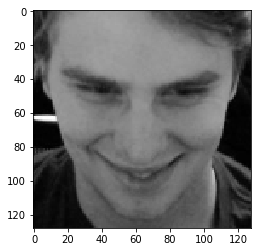

In [6]:
idx = np.random.randint(0,len(labels))
plt.imshow(images[idx], cmap="gray")
print("\t\t"+str(labels[idx]))

In [7]:
import random
def balanced_subset(images,labels):
    #np.warnings.filterwarnings('ignore')
    count = Counter(labels)
    perclass_count = np.array([[c,count[c]] for c in count.keys()])
    max_n = min(perclass_count[:,1])
    
    perclass_indexes = {cname:random.sample(range(0, n), max_n) for cname,n in perclass_count}
    perclass_index = {label:0 for label in count.keys()}
    
    newlabels = []
    newimages = []
    total = 0
    for i in range(len(labels)):
        
        label = labels[i]

        if perclass_index[label] in perclass_indexes[label]:
            total += 1
            newlabels.append(label)
            newimages.append(images[i])
        perclass_index[label] += 1
            
    newimages, newlabels = np.array(newimages),np.array(newlabels)   
        
    #print(perclass_count,perclass_indexes)
    return newimages, newlabels

In [8]:
from collections import Counter
labels = [x.lower() for x in labels]
count = Counter(labels)
#print(c.most_common())
label2int = {y:x for x,(y,_) in enumerate(count.most_common())}
int2label = {label2int[key]:key for key in label2int.keys()}

nplabels = np.array([label2int[x] for x in labels])
assert(len(nplabels) == len(images))
print("count:",count.most_common(),"\n")

count: [('happy', 250), ('sad', 250), ('neutral', 249), ('angry', 249)] 



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train, x_val, y_train, y_val = train_test_split(images, nplabels, test_size=.05)
len(y_val)

50

In [10]:
def next_batch(images, labels, batch_size):
    images, labels = shuffle(images,labels)
    for i in range(0,len(labels),batch_size):
        if i+batch_size >= len(labels):
            yield images[i:],labels[i:]
        else:
            yield images[i:i+batch_size],labels[i:i+batch_size]

In [11]:
print(images[0].shape)

(128, 128)


# Build Model

In [14]:
import tensorflow as tf
from Expression_Network import Expression_Network

In [15]:
num_classes = len(count.most_common())
x = tf.placeholder(dtype=tf.float32, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.int32, shape=(None),name="y")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")
one_hot = tf.one_hot(y,num_classes)
reshaped = tf.expand_dims(x,-1)

exnet = Expression_Network(num_classes,Training=True)
logits,prediction = exnet.model(x)

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot)
loss_op = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(lr).minimize(loss_op)
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(one_hot,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [18]:
epochs = 20
learn_rate = .0001
batch_size = 32

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch in range(epochs):
        batch_i = 1
        
        for x_batch,y_batch in next_batch(x_train,y_train,batch_size):
            sess.run(optimizer,feed_dict={x:x_batch,y:y_batch,lr:learn_rate})
        
            if batch_i % 10 == 0:
            
                valacc = sess.run(accuracy,feed_dict={x:x_val,y:y_val})
                loss, trainacc = sess.run([loss_op, accuracy], feed_dict={x:x_train,y:y_train})
                print("epoch:{} batch:{}\ttrain accuracy: {}\tloss: {}\tval acc: {}"
                 .format(epoch,batch_i,round(float(trainacc),4),round(float(loss),4), round(float(valacc),4)))
                
                
            batch_i += 1
    X,Y = balanced_subset(images,nplabels)
    X,Y = shuffle(X,Y)
    #print(sess.run(prediction,feed_dict={x:X,y:Y}))
    
  
    save_path = saver.save(sess, "checkpoints/model.ckpt")

            

epoch:0 batch:10	train accuracy: 0.2363	loss: 24.5807	val acc: 0.22
epoch:0 batch:20	train accuracy: 0.2743	loss: 25.2867	val acc: 0.24
epoch:0 batch:30	train accuracy: 0.3523	loss: 13.4603	val acc: 0.42
epoch:1 batch:10	train accuracy: 0.3829	loss: 13.5296	val acc: 0.42
epoch:1 batch:20	train accuracy: 0.4335	loss: 10.6212	val acc: 0.52
epoch:1 batch:30	train accuracy: 0.423	loss: 13.256	val acc: 0.48
epoch:2 batch:10	train accuracy: 0.4335	loss: 14.7839	val acc: 0.42
epoch:2 batch:20	train accuracy: 0.6171	loss: 5.6573	val acc: 0.54
epoch:2 batch:30	train accuracy: 0.6561	loss: 4.2414	val acc: 0.62
epoch:3 batch:10	train accuracy: 0.5812	loss: 6.4494	val acc: 0.52
epoch:3 batch:20	train accuracy: 0.6129	loss: 5.6947	val acc: 0.5
epoch:3 batch:30	train accuracy: 0.6698	loss: 4.4643	val acc: 0.62
epoch:4 batch:10	train accuracy: 0.6941	loss: 4.1496	val acc: 0.68
epoch:4 batch:20	train accuracy: 0.7679	loss: 2.377	val acc: 0.72
epoch:4 batch:30	train accuracy: 0.7975	loss: 2.1509	val ac

UnknownError: Failed to rename: checkpoints/model.ckpt.data-00000-of-00001.tempstate9252437243531276833 to: checkpoints/model.ckpt.data-00000-of-00001 : Access is denied.
; Input/output error
	 [[node save_1/SaveV2 (defined at <ipython-input-18-e212846be9b4>:7)  = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, Conv/biases/_23, Conv/biases/Adam/_25, Conv/biases/Adam_1/_27, Conv/weights/_29, Conv/weights/Adam/_31, Conv/weights/Adam_1/_33, Conv_1/biases/_35, Conv_1/biases/Adam/_37, Conv_1/biases/Adam_1/_39, Conv_1/weights/_41, Conv_1/weights/Adam/_43, Conv_1/weights/Adam_1/_45, beta1_power/_47, beta2_power/_49, fully_connected/biases/_51, fully_connected/biases/Adam/_53, fully_connected/biases/Adam_1/_55, fully_connected/weights/_57, fully_connected/weights/Adam/_59, fully_connected/weights/Adam_1/_61, fully_connected_1/biases/_63, fully_connected_1/biases/Adam/_65, fully_connected_1/biases/Adam_1/_67, fully_connected_1/weights/_69, fully_connected_1/weights/Adam/_71, fully_connected_1/weights/Adam_1/_73)]]

Caused by op 'save_1/SaveV2', defined at:
  File "c:\users\ablac\miniconda3\envs\expressions\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-e212846be9b4>", line 7, in <module>
    saver = tf.train.Saver()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 1102, in __init__
    self.build()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 792, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 284, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 202, in save_op
    tensors)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1804, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to rename: checkpoints/model.ckpt.data-00000-of-00001.tempstate9252437243531276833 to: checkpoints/model.ckpt.data-00000-of-00001 : Access is denied.
; Input/output error
	 [[node save_1/SaveV2 (defined at <ipython-input-18-e212846be9b4>:7)  = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, Conv/biases/_23, Conv/biases/Adam/_25, Conv/biases/Adam_1/_27, Conv/weights/_29, Conv/weights/Adam/_31, Conv/weights/Adam_1/_33, Conv_1/biases/_35, Conv_1/biases/Adam/_37, Conv_1/biases/Adam_1/_39, Conv_1/weights/_41, Conv_1/weights/Adam/_43, Conv_1/weights/Adam_1/_45, beta1_power/_47, beta2_power/_49, fully_connected/biases/_51, fully_connected/biases/Adam/_53, fully_connected/biases/Adam_1/_55, fully_connected/weights/_57, fully_connected/weights/Adam/_59, fully_connected/weights/Adam_1/_61, fully_connected_1/biases/_63, fully_connected_1/biases/Adam/_65, fully_connected_1/biases/Adam_1/_67, fully_connected_1/weights/_69, fully_connected_1/weights/Adam/_71, fully_connected_1/weights/Adam_1/_73)]]


In [31]:
batch_i = np.array(0)
trainacc = np.array(0.238473172372)
loss = np.array(12314.52365646352)

In [34]:
print("batch: {}\ttrain accuracy: {}\tloss: {}"
                      .format(batch_i,np.round(trainacc,4),np.round(loss,4)))

batch: 0	train accuracy: 0.2385	loss: 12314.5237


In [36]:
num_classes = len(count.most_common())
x = tf.placeholder(dtype=tf.float64, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.int32, shape=(None),name="y")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")

In [38]:
#batch,128,128,1

#first convolution
conv = tf.contrib.layers.conv2d(
    reshaped,
    32,
    (9,9),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,120,120,32

#subsample
pool = tf.contrib.layers.max_pool2d(
    conv,
    (4,4),
    stride=(4,4))
#batch,30,30,32

#second convolution
conv2 = tf.contrib.layers.conv2d(
    pool,
    64,
    (11,11),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,20,20,64

#subsample
pool2 = tf.contrib.layers.max_pool2d(
    conv2,
    (4,4),
    stride=(4,4))
#batch,5,5,64

#flatten
flat = tf.contrib.layers.flatten(pool2)
#batch,1600

#fully connected
fc = tf.contrib.layers.fully_connected(
    flat,
    256,
    activation_fn=tf.nn.leaky_relu)

#batch,256
logits = tf.contrib.layers.fully_connected(
    fc,
    num_classes,
    activation_fn=None)

prediction = tf.nn.softmax(logits,)

In [28]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "checkpoints/model.ckpt")
    sess.run()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
